# This notebook is dedicated to a end to end topic modelling using gensim first of all we need to import some of the libraries 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Now lets import NLTk for removing the stop words there are certain words those are need to be included

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

# Now lets import a dataset which talks about several topics that we dont know about 

In [7]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(len(df.target_names.unique()))
df.head()

20


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [8]:
df.target_names

0                       rec.autos
1           comp.sys.mac.hardware
10                rec.motorcycles
100                  misc.forsale
1000      comp.os.ms-windows.misc
10000                   rec.autos
10001                misc.forsale
10002     comp.os.ms-windows.misc
10003                 alt.atheism
10004                 alt.atheism
10005               comp.graphics
10006          rec.sport.baseball
10007             rec.motorcycles
10008            rec.sport.hockey
10009             sci.electronics
1001                    rec.autos
10010                   sci.space
10011          talk.politics.misc
10012       comp.sys.mac.hardware
10013                   sci.space
10014                 alt.atheism
10015                     sci.med
10016     comp.os.ms-windows.misc
10017       talk.politics.mideast
10018                misc.forsale
10019      soc.religion.christian
1002           talk.politics.misc
10020      soc.religion.christian
10021          rec.sport.baseball
10022         

# Now we preprocesss the data by excluding or removing special characters and unwanted strings

In [9]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [10]:
# this step removes the punctuation from the data
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [11]:
# Making bigrams and trigrams 
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [14]:
print(data_lemmatized[:2])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'si', 'clock', 'report', 'keyword', 'acceleration', 'clock', 'upgrade', 'article', 'shelley', 'qvfo', 'innc', 'organization', 'university', 'washington', 'line', 'nntp_post', 'host', 'carson_washington', 'fair', 'number', 'brave', 'soul', 'upgrade', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'sp

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [16]:
print(corpus[:2])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)], [(5, 2), (8, 2), (16, 1), (21, 1), (29, 1), (30, 1), (43, 1), (46, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 5), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 3), (101, 1), (102, 1)]]


In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.012*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

In [20]:
# scoring the topic modeling
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754123661303712

Coherence Score:  0.5152202258019667


In [21]:
# Visualizing the model
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.336978 -0.001277       1        1  16.258047
13     0.291075 -0.003103       2        1  15.227721
18     0.328797 -0.128179       3        1  14.570779
2      0.091756  0.226458       4        1   6.162413
15     0.059666  0.222613       5        1   5.973709
10    -0.084990 -0.112869       6        1   4.344126
17     0.060983 -0.182982       7        1   4.177851
12    -0.022526 -0.036459       8        1   3.586201
5     -0.022911 -0.021268       9        1   3.365437
16    -0.029288  0.219738      10        1   3.271720
6     -0.062703 -0.017222      11        1   3.227786
9     -0.062847  0.139472      12        1   2.969724
14    -0.088858 -0.062627      13        1   2.741284
3     -0.047748 -0.117467      14        1   2.731820
8     -0.111492  0.003695      15        1   2.290865
19    -0.113678 -0.023380      16        1   2.124074
11    -0.092186 -0.110820      17        1   2.081729
4     -0.134206  0.001647      18        1   1.693803
0     -0.164200 -0.027981      19        1   1.679179
1     -0.131620  0.032009      20        1   1.521725, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16294.000000           not  16294.000000  28.0000  28.0000
30     Default  11141.000000  organization  11141.000000  27.0000  27.0000
3721   Default   3845.000000           max   3845.000000  26.0000  26.0000
65     Default  10454.000000            do  10454.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8048.000000            be   8048.000000  22.0000  22.0000
154    Default  11783.000000         would  11783.000000  21.0000  21.0000
303    Default   6906.000000           say   6906.000000  20.0000  20.0000
226    Default   5804.000000            go   5804.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7292.000000          know   7292.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1948.000000          mail   1948.000000   7.0000   7.0000
681    Default   3006.000000         right   3006.000000   6.0000   6.0000
967    Default   1684.000000     christian   1684.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.370918          guru    120.322800   4.1774  -5.3259
3548   Topic20    117.623421  countersteer    118.575302   4.1773  -5.3407
10436  Topic20    113.026093       bradley    113.977974   4.1769  -5.3805
280    Topic20    112.216736          lane    113.168617   4.1769  -5

In [34]:
import os
os.environ.update({'MALLET_HOME':r'C:/Users/piyushs/Desktop/mallet_2.0.8'})
mallet_path = 'C:\\Users\\piyushs\\Desktop\\mallet_2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('god', 0.022673656618610746),
   ('christian', 0.017943524365542713),
   ('people', 0.010770880495651138),
   ('religion', 0.008578577385916835),
   ('bible', 0.008399857023710235),
   ('word', 0.007756463719766472),
   ('man', 0.0075896580483736445),
   ('church', 0.007577743357559871),
   ('faith', 0.0068986059811747885),
   ('love', 0.006684141546526867)]),
 (0,
  [('good', 0.028501017893496197),
   ('year', 0.020804314439801422),
   ('run', 0.01266116647023108),
   ('game', 0.012482588663880852),
   ('hit', 0.009893210471802564),
   ('win', 0.009589628201007179),
   ('organization', 0.009446765955926997),
   ('line', 0.008643165827350977),
   ('team', 0.007214543376549163),
   ('player', 0.007035965570198936)]),
 (1,
  [('_', 0.05402277277277277),
   ('organization', 0.015233983983983984),
   ('ca', 0.012887887887887887),
   ('line', 0.010135135135135136),
   ('cx', 0.005536786786786787),
   ('air', 0.005317817817817818),
   ('ad', 0.004786036036036036),
   ('newsreader_t

In [36]:
# as we improved our coherence score its time to know the optimal topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

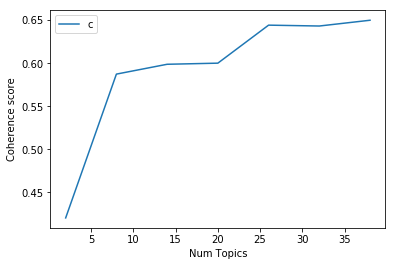

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4203
Num Topics = 8  has Coherence Value of 0.5873
Num Topics = 14  has Coherence Value of 0.5987
Num Topics = 20  has Coherence Value of 0.6
Num Topics = 26  has Coherence Value of 0.6442
Num Topics = 32  has Coherence Value of 0.6432
Num Topics = 38  has Coherence Value of 0.6499


In [40]:
# Before flattening 
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.022*"people" + 0.018*"state" + 0.017*"law" + 0.015*"government" + '
  '0.012*"make" + 0.009*"issue" + 0.008*"case" + 0.008*"public" + 0.007*"bill" '
  '+ 0.007*"article"'),
 (1,
  '0.019*"time" + 0.014*"back" + 0.013*"people" + 0.013*"thing" + '
  '0.013*"leave" + 0.011*"start" + 0.010*"happen" + 0.010*"day" + 0.009*"hear" '
  '+ 0.009*"make"'),
 (2,
  '0.846*"ax" + 0.062*"max" + 0.004*"db_db" + 0.002*"tm" + 0.002*"qax" + '
  '0.001*"_" + 0.001*"giz" + 0.001*"mf" + 0.001*"ml" + 0.001*"fp"'),
 (3,
  '0.025*"key" + 0.019*"space" + 0.010*"system" + 0.009*"encryption" + '
  '0.008*"technology" + 0.007*"security" + 0.007*"chip" + 0.006*"bit" + '
  '0.006*"launch" + 0.006*"datum"'),
 (4,
  '0.024*"game" + 0.019*"team" + 0.015*"year" + 0.014*"play" + 0.013*"good" + '
  '0.012*"player" + 0.011*"win" + 0.008*"season" + 0.007*"hockey" + '
  '0.006*"fan"'),
 (5,
  '0.019*"god" + 0.019*"christian" + 0.010*"people" + 0.009*"bible" + '
  '0.008*"man" + 0.008*"church" + 0.008*"word" + 0.007

In [42]:
### Finding dominant topic
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.1982,"car, article, write, line, bike, organization,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,11.0,0.1784,"drive, problem, system, card, scsi, bit, drive...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,13.0,0.3433,"car, article, write, line, bike, organization,...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,16.0,0.2697,"file, image, software, mail, system, version, ...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,11.0,0.2230,"drive, problem, system, card, scsi, bit, drive...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,13.0,0.4582,"car, article, write, line, bike, organization,...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,14.0,0.1667,"line, organization, write, article, nntp_post,...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,19.0,0.1574,"line, organization, mail, sale, price, good, s...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,15.0,0.1619,"question, write, exist, claim, point, thing, r...",Subject: Re: Dont more innocents die without t...
9,9,15.0,0.3885,"question, write, exist, claim, point, thing, r...",From: (Jon Livesey) Subject: Re: Genocide is C...


In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,13.0,"car, article, write, line, bike, organization,...",411.0,0.0363
1,11.0,"drive, problem, system, card, scsi, bit, drive...",163.0,0.0144
2,13.0,"car, article, write, line, bike, organization,...",11.0,0.0010
3,16.0,"file, image, software, mail, system, version, ...",818.0,0.0723
4,11.0,"drive, problem, system, card, scsi, bit, drive...",1067.0,0.0943
5,13.0,"car, article, write, line, bike, organization,...",735.0,0.0650
6,14.0,"line, organization, write, article, nntp_post,...",388.0,0.0343
7,19.0,"line, organization, mail, sale, price, good, s...",578.0,0.0511
8,15.0,"question, write, exist, claim, point, thing, r...",570.0,0.0504
9,15.0,"question, write, exist, claim, point, thing, r...",160.0,0.0141
